In this notebook I will give a shot at implementing a digit recognition NN using the Keras library for python. This notebook is inspired by [Poonam Ligade's notebook](https://www.kaggle.com/poonaml/deep-neural-network-keras-way/notebook/notebook) on Kaggle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Example label:  7


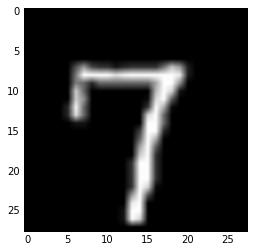

In [4]:
# choose example to plot
iexample=6

# plot example
pixels=df_train.iloc[iexample,1:].reshape(28,28)
plt.imshow(pixels,cmap='gray')

# check example label
print('Example label: ',df_train['label'][iexample])

### Preprocessing image data
Here we write a function to renormalize (standardize) the input data (center around zero and divide by variance)

In [5]:
# Note that Keras takes numpy arrays as input!
X_total = np.array(df_train.drop(["label"],1),dtype="f")#f --> float32
y_labels = np.array(df_train["label"])

In [6]:
mean_train = X_total.mean(axis=0)
var_train = X_total.var(axis=0)
def standardize(x):
    tmp = (x - mean_train)/var_train
    return np.nan_to_num(tmp)
X_total = standardize(X_total)
print(len(X_total))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


42000


In [52]:
print(X_total[iexample].shape)

(28, 28, 1)


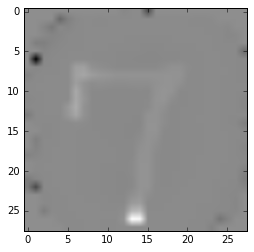

In [53]:
#### Re-plot example after standardization
pixels=X_total[iexample].reshape(28,28)
plt.imshow(pixels,cmap='gray')


In [7]:
### reshape train and test data, in order to use Keras ImageDataGenerator preprocesser 
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
X_total = X_total.reshape(len(X_total),28,28,1)
X_total.shape

(42000, 28, 28, 1)

In [8]:
### Changing y_total from continuous label to one-hot vector
# My implementation
# y_total = np.zeros((len(y_labels),10))
# y_total[np.arange(len(y_labels)),y_labels] = 1
# works fine, but better use Keras. (In fact checking the Keras source code, it performs almost exactly the same operation)

from keras.utils.np_utils import to_categorical
y_total = to_categorical(y_labels)

### Split data into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(X_total, y_total, test_size=0.10, random_state=42)

Using TensorFlow backend.


In [9]:
X_train.shape

(37800, 28, 28, 1)

In [10]:
print(y_total[0:5])
y_labels[0:5]
### Result looks correct

[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


array([1, 0, 1, 4, 0])

Next up, I will use Keras to generate a sequental NN for digit recognition. Tutorials can be found on the [Keras website](https://keras.io/getting-started/sequential-model-guide/#examples)

In [64]:
# inspired from https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-7
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.preprocessing import image

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [66]:
model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])
model.summary() ## Very useful function to check if the NN does what you expect it to do

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 40)                184360    
_________________________________________________________________
dropout_16 (Dropout)         (None, 40)                0         
__________

In [37]:
#### Image preprocessing
### Sources: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
### https://keras.io/preprocessing/image/
### BEST EXPLANATION http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

batch_size = 30
epochs = 10

# this is the augmentation configuration we will use for training
datagen = image.ImageDataGenerator(
        #NOTE: featurewise_center and featurewise_std_normalization are just what I am doing with the standardization function
        featurewise_center=False,
        featurewise_std_normalization=False,
        # rotation maybe not helpful here, since the data has normalized orientation
        #rotation_range=20,
        shear_range=0.1,
        #zoom_range=0.2,
        horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs)

Epoch 1/2
   1/1181 [..............................] - ETA: 74s - loss: 0.2293 - acc: 0.9375

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (37800, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


1182/1181 [==============================] - 47s - loss: 0.1008 - acc: 0.9671    
Epoch 2/2
1182/1181 [==============================] - 47s - loss: 0.1068 - acc: 0.9652    


In [38]:
### Evaluate on the cross validation set
model.evaluate(X_cv, y_cv, batch_size=30)

4128/4200 [============================>.] - ETA: 0s

[0.052384199464845765, 0.98523809523809525]

#### Conclusion:
This CNN gives the best result so far (98,9% accuracy --> 0.989 Kaggle score)

In [19]:
#### classification report #####
predictions_train = model.predict_classes(X_train, verbose=0)
y_train_labels = y_train.argmax(axis=-1)
print('classification report for digit identifier:\n',classification_report(predictions_train,y_train_labels))

classification report for digit identifier:
              precision    recall  f1-score   support

          0       0.99      1.00      1.00      3717
          1       1.00      1.00      1.00      4217
          2       0.99      0.99      0.99      3787
          3       0.99      1.00      0.99      3815
          4       0.99      0.99      0.99      3688
          5       0.99      0.99      0.99      3464
          6       1.00      0.99      0.99      3751
          7       0.99      0.99      0.99      3947
          8       0.99      0.99      0.99      3674
          9       0.98      0.99      0.99      3740

avg / total       0.99      0.99      0.99     37800



In [20]:
############################
##### CONFUSION MATRIX #####
############################
# https://en.wikipedia.org/wiki/Confusion_matrix
# die confusion matrix zeigt an, wie die labels des training sets klassifiziert wurden. 
# Zum Beispiel wurde '0' acht mal als '6' falsch klassifiziert. Interessanterweise, nie als '9'
# Man sieht, dass '9' sehr oft mit '4' oder '7' verwechselt wird (17 Mal)
confusion_matrix(y_train_labels, predictions_train)

array([[3703,    0,    4,    1,    1,    3,    8,    1,    3,    0],
       [   0, 4198,    7,    2,    3,    0,    2,    1,    0,    0],
       [   1,    2, 3738,    3,    2,    1,    1,    4,    3,    2],
       [   1,    1,   12, 3801,    0,   14,    0,    3,    9,    4],
       [   1,    4,    3,    0, 3654,    0,    5,    2,    0,    6],
       [   0,    0,    1,    5,    1, 3427,   12,    0,   10,    0],
       [   4,    0,    0,    0,    3,    6, 3719,    0,    3,    0],
       [   1,    8,   17,    0,    7,    2,    0, 3919,    1,    8],
       [   0,    2,    4,    1,    0,    4,    4,    0, 3637,    8],
       [   6,    2,    1,    2,   17,    7,    0,   17,    8, 3712]])

Note: Using a larger fully connected layer (100 nodes) leads to overfitting with a training accuracy of 99.1%, but a test score of 98.2%, i.e. less than the 98.4% which I got with less hidden nodes..

In [47]:
# Save the model weights...
model.save('CNNmodel_weights')

### Try more convolution layers with some stride>1 convolutional layers instead of pooling

In [29]:
#https://www.kaggle.com/c/digit-recognizer/discussion/23999
from keras.layers.convolutional import ZeroPadding2D
model = Sequential()

model.add(ZeroPadding2D(5, input_shape=X_train.shape[1:]))
model.add(Convolution2D(30, 9, activation='relu'))
model.add(ZeroPadding2D(1, input_shape=X_train.shape[1:]))
model.add(Convolution2D(40, 3, activation='relu'))
model.add(ZeroPadding2D(2, input_shape=X_train.shape[1:]))
model.add(Convolution2D(40, 5, activation='relu',strides=(2, 2)))
model.add(ZeroPadding2D(2, input_shape=X_train.shape[1:]))
model.add(Convolution2D(40, 3, activation='relu'))
model.add(ZeroPadding2D(2, input_shape=X_train.shape[1:]))
model.add(Convolution2D(20, 5, activation='relu',strides=(2, 2)))
model.add(ZeroPadding2D(1, input_shape=X_train.shape[1:]))
model.add(Convolution2D(20, 3, activation='relu'))
model.add(ZeroPadding2D(1, input_shape=X_train.shape[1:]))
model.add(Convolution2D(20, 5, activation='relu',strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              #optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

In [38]:
batch_size = 32
epochs = 1



# this is the augmentation configuration we will use for training
datagen = image.ImageDataGenerator(
        #NOTE: featurewise_center and featurewise_std_normalization are just what I am doing with the standardization function
        featurewise_center=False,
        featurewise_std_normalization=False,
        #rescale=1./255,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        # added a little rotation
        rotation_range=10,
        shear_range=0.1,
        #zoom_range=0.2,
        horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (32000, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/1
1000/1000 [==============================] - 193s - loss: 0.1372 - acc: 0.9663   


In [37]:
model.evaluate(X_cv, y_cv, batch_size=32)

8000/8000 [==============================] - 17s    


[0.060812906496194044, 0.98550000000000004]

In [39]:
model.evaluate(X_cv, y_cv, batch_size=32)

8000/8000 [==============================] - 17s    


[0.073354644408593225, 0.98262499999999997]

#### Conlcusion:
This takes much longer to train but it does not lead to a much improved score on the Kaggle test set

### Try other CNN - more filters

In [45]:
# https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-7
from keras.layers import Conv2D, MaxPooling2D, Dropout

model2 = Sequential()

model2.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=X_train.shape[1:]))
## Here, I added more filters
model2.add(Conv2D(64, kernel_size=5, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
## Here, I add another convoluational layer
model2.add(Conv2D(32, kernel_size=3, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(40, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              #optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

In [ ]:
batch_size = 30
epochs = 10

# this is the augmentation configuration we will use for training
datagen = image.ImageDataGenerator(
        #NOTE: featurewise_center and featurewise_std_normalization are just what I am doing with the standardization function
        featurewise_center=False,
        featurewise_std_normalization=False,
        #rescale=1./255,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        # rotation is not helpful here, since the data has normalized orientation
        #rotation_range=20,
        shear_range=0.1,
        #zoom_range=0.2,
        horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model2.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs)

Epoch 1/5
   1/1181 [..............................] - ETA: 136s - loss: 0.0459 - acc: 1.0000

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (37800, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


 667/1181 [===============>..............] - ETA: 46s - loss: 0.1700 - acc: 0.9516

# TODO 
- Try active learning for digit recognition: http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-active-learning-py

--------

## Kaggle test set predictions

In [32]:
X_test = np.array(df_test,dtype="f")
print(X_test.dtype)
X_test = standardize(X_test)
X_test = X_test.reshape(len(X_test),28,28,1)


float32


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [31]:
X_test.shape

(28000, 784)

In [39]:
predictions = model.predict_classes(X_test, verbose=0)

In [40]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("pred_sub.csv", index=False, header=True)